In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from math import sqrt
from numpy import round, clip
from sklearn.model_selection import cross_val_score
print("environment checked!")

environment checked!


In [2]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 数据部分

比赛数据导入，重命名特征列，方便理解，实验数据为data，预测数据为pred_data

In [3]:
# 导入比赛数据（train,test)以及原始数据（uci-dataset）
data = pd.read_csv("./data/playground-series-s4e4/train.csv",index_col="id")
pred_data = pd.read_csv("./data/playground-series-s4e4/test.csv",index_col="id")

columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
data.columns = columns
pred_data.columns = columns[:-1]
data.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


独热编码Sex

In [4]:
data_encoded = pd.get_dummies(data, columns=['Sex'], dtype=int)
data_encoded.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
id,,,,,,,,,,,
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,1,0,0
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,1,0,0
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0,1,0
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0,0,1
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0,1,0


二元编码，因为FM分布几乎一样，弃用，不如独热编码

In [5]:
# # 创建一个新列，根据'Sex'列的值用1或0填充
# data['Sex_encoded'] = data['Sex'].apply(lambda x: 1 if x in ['F', 'M'] else 0)
# 
# # 现在，您可以选择删除原始的'Sex'列
# data.drop('Sex', axis=1, inplace=True)
# 
# # 展示前几行以确认结果
# data.head()
# data_bin = data

合成特征，比如体积比较有意义，壳密度，长宽比，壳重和去壳重量比，后续补充对Height的裁剪

In [43]:
# Height 有 0 值
data_encoded["Height"] = data_encoded["Height"].clip(upper=0.2,lower=0.02)
data_encoded["Volume"] = data_encoded["Length"] * data_encoded["Diameter"] * data_encoded["Height"]
data_encoded["Density"] = data_encoded["Shell_weight"] / data_encoded["Volume"]
data_encoded["AspectRatio"] = data_encoded["Length"] / data_encoded["Diameter"]
data_encoded["ShellRatio"] = data_encoded["Shell_weight"] / data_encoded["Shucked_weight"]
data_encoded.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M,Volume,Density,AspectRatio,ShellRatio
id,,,,,,,,,,,,,,,
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,1,0,0,0.035475,6.765328,1.279070,0.730594
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,1,0,0,0.044761,7.149001,1.285714,0.698690
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0,1,0,0.000440,11.363636,1.454545,0.909091
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0,0,1,0.042394,5.897096,1.252632,0.665779
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0,1,0,0.030664,6.440830,1.305882,0.534506


计算相关性,最后结果只有体积和壳重比比较好。很奇怪，性别为什么相关性差，暂时保留

C:\Users\gusuc\.conda\envs\PS4E4\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


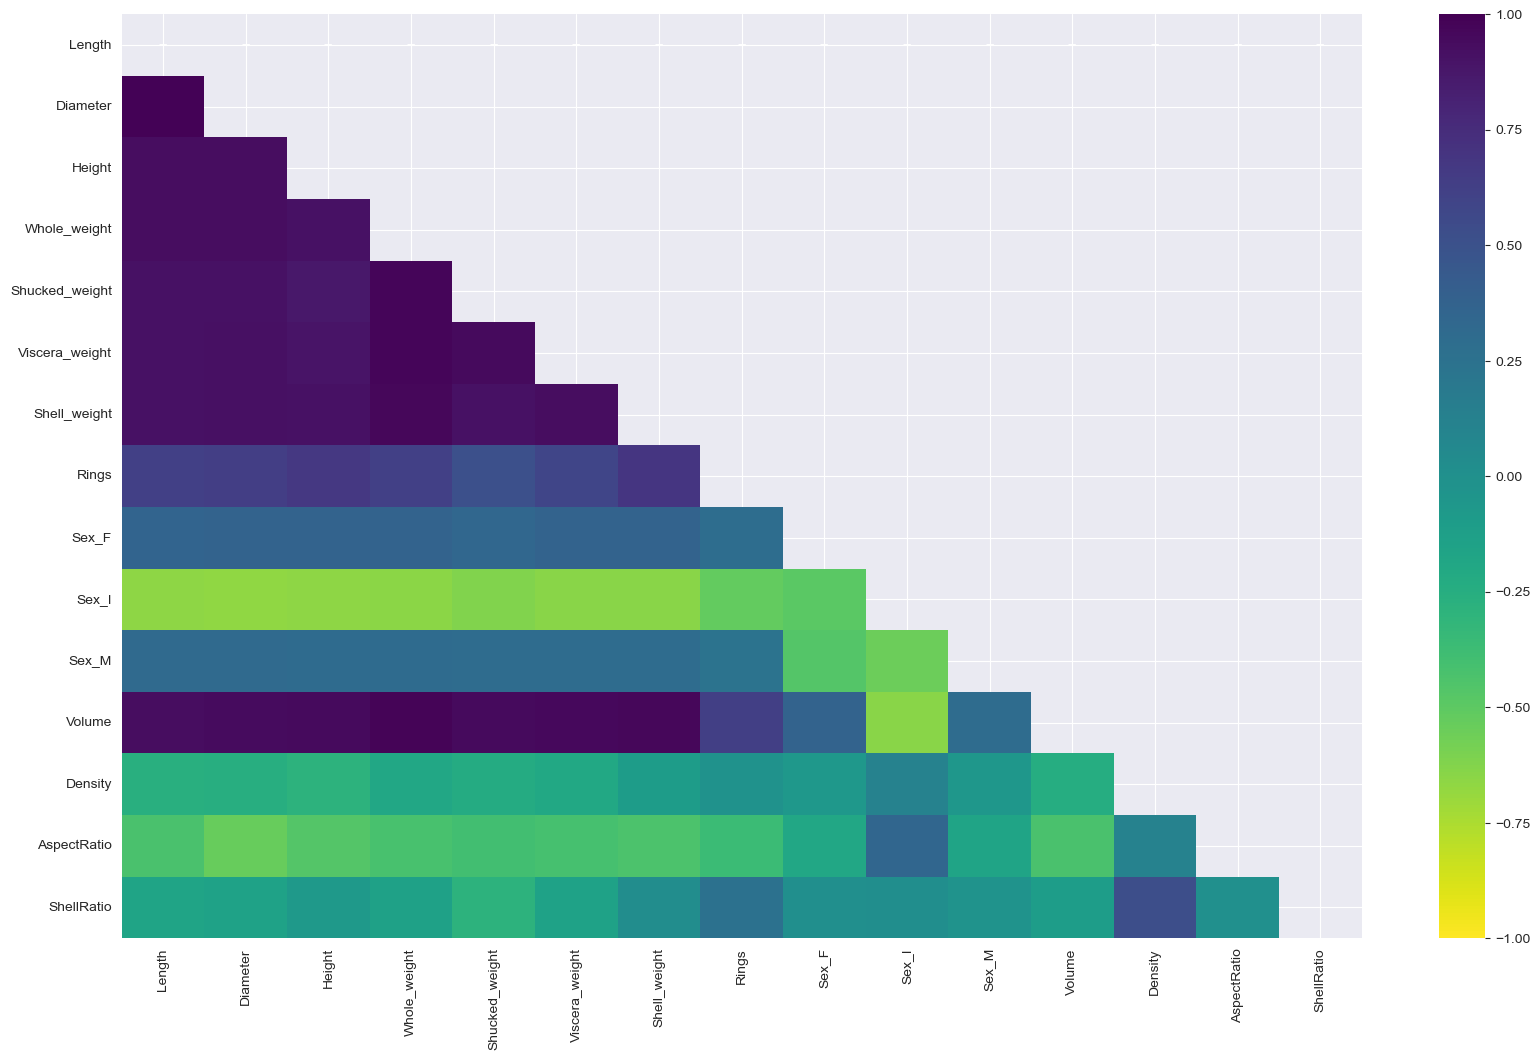

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
mask = np.triu(np.ones_like(data_encoded.corr()))
plt.figure(figsize=(20,12))
sns.heatmap(data_encoded.corr(), cmap="viridis_r", annot=True, mask=mask,vmin=-1,vmax=1);

In [46]:
# 原始：data
# 独热编码:data_encoded
# 2元编码：data_bin
# 结论，独热编码效果最好
features=['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', "Volume", "ShellRatio"]
X = data_encoded[features]
y = data_encoded.Rings
# 使用K折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmsle_list = []
X.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Volume,ShellRatio
id,,,,,,,,,
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,0.035475,0.730594
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,0.044761,0.698690
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,0.000440,0.909091
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,0.042394,0.665779
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,0.030664,0.534506


# 模型部分

## XGBoost

In [71]:
# 参数调整
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.3,
    'max_depth': 6,
    'alpha': 10,
    'n_estimators': 150
}

In [72]:
from tqdm.notebook import tqdm  # 注意: 在Jupyter Notebook中使用tqdm.notebook

rmsle_list = []  # 确保这个列表在循环开始前已经被初始化

# 将kf.split(X)封装在tqdm()中，以显示进度条
for train_index, test_index in tqdm(kf.split(X), total=kf.get_n_splits(), desc="Training Progress"):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 训练模型
    xg_reg = xgb.XGBRegressor(**params)
    xg_reg.fit(X_train, y_train)
    
    # 预测测试集
    y_pred = xg_reg.predict(X_test)
    
    # 计算RMSLE
    rmsle = sqrt(mean_squared_log_error(y_test, y_pred))
    rmsle_list.append(rmsle)

# 计算平均RMSLE
average_rmsle = sum(rmsle_list) / len(rmsle_list)
print("Average RMSLE: %f" % (average_rmsle))

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Average RMSLE: 0.151672


三个baseline models
xgboost,lightgbm,catboost

In [47]:
xgbmodel = xgb.XGBRegressor(random_state=42)
print("CV RMSLE score of XGB is ",np.sqrt(-cross_val_score(xgbmodel,X,y,cv=4, scoring = 'neg_mean_squared_log_error').mean()))

CV RMSLE score of XGB is  0.15169608723679645


In [48]:
lgbmmodel = LGBMRegressor(random_state=42, verbose=-1)
print("CV RMSLE score of LGBM is ",np.sqrt(-cross_val_score(lgbmmodel,X,y,cv=4, scoring = 'neg_mean_squared_log_error').mean()))

CV RMSLE score of LGBM is  0.15163457461182844


In [49]:
catmodel = CatBoostRegressor(random_state=42, verbose=0)
print("CV RMSLE score of CAT is ",np.sqrt(-cross_val_score(catmodel,X,y,cv=4, scoring = 'neg_mean_squared_log_error').mean()))

CV RMSLE score of CAT is  0.15078453954312898
